# Detailed Exploration of Universal Gate Set for small zeta

## Header

In [52]:
import numpy as np
import QDYN
from QDYN.shutil import mkdir
from QDYN.pulse import Pulse, pulse_tgrid
from QDYN.gate2q import Gate2Q
from QDYN.linalg import norm, vectorize
from os.path import join
from notebook_utils import (
    get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table,
    get_stage4_table, bare_decomposition, get_transition_table, J_target,
    get_w_d_from_config, read_target_gate)
from mgplottools.io import writetotxt
from select_for_stage4 import GATE_RE, GATE_IM, GATE
from generate_zeta_universal import write_config
from analytical_pulses import AnalyticalPulse
from run_oct import propagate
from collections import OrderedDict
from zeta_systematic_variation import systematic_variation
import pandas as pd
import QDYNTransmonLib
from mgplottools.io import writetotxt
import json

In [78]:
H_left = GATE['H_left']
H_right = GATE['H_right']
S_left = GATE['Ph_left']
S_right = GATE['Ph_right']
sqrt_SWAP = QDYN.gate2q.sqrt_SWAP
GATE_RE['sqrt_SWAP'] = QDYN.linalg.vectorize(sqrt_SWAP).real
GATE_IM['sqrt_SWAP'] = QDYN.linalg.vectorize(sqrt_SWAP).imag
def write_target_gate_dat(rf, gate):
    writetotxt(join(rf, 'target_gate.dat'), GATE_RE[gate], GATE_IM[gate])

In [3]:
def J_PE(U):
    if U is None:
        return None
    else:
        C = U.closest_unitary().concurrence()
        max_loss = np.max(1.0 - U.logical_pops())
        return J_target('PE', C, max_loss)

def F_avg_H_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_left)
    
def F_avg_H_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_right)

def F_avg_S_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_left)
    
def F_avg_S_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_right)

In [4]:
from multiprocessing import Process
import os
def system(cmd):
    p = Process(target=os.system, args=(cmd,))
    p.start()
    return p

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [7]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

In [8]:
w_max = 1.0 # minimum frequency in the rotating frame to be resolved. (for calculation of nt)

In [9]:
n_qubit = 5; n_cavity = 6

In [10]:
def mark_freqs(rf, transition_table):
    """Return the frequencies that should be highlighted in the spectrum plot"""
    w_d = get_w_d_from_config(join(rf, 'config'))
    w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
    w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
    w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
    w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz
    wc = 6.2 # GHZ
    w2 = 5.9 # GHz
    w1 = 6.00 # GHz
    return [(w1_dressed0-w_d, {'color':'black', 'ls':'--'}),
            (w1_dressed1-w_d, {'color':'black', 'ls':'--'}),
            (w2_dressed0-w_d, {'color':'gray', 'ls':'--'}),
            (w2_dressed1-w_d, {'color':'gray', 'ls':'--'}),
            (wc-wd,           {'color':'gray', 'ls':'dotted'}),
            (w2-wd,           {'color':'gray', 'ls':'-.'}),
            (w1-wd,           {'color':'black', 'ls':'-.'})]

## Properties of the Hamiltonian

In [11]:
wc = 6.2 # GHZ
w2 = 5.9 # GHz
w1 = 6.00 # GHz
root = './runs_zeta_detailed/w2_%dMHz_wc_%dMHz' % (w2*1000, wc*1000)
mkdir(root)

* what is the the entangling energy?

In [12]:
zeta = float(filter_table(zeta_table, [(w2, wc),])['zeta [MHz]']); zeta

0.29699999999999704

In [13]:
T_entangling = 500.0 / abs(zeta); T_entangling # ns

1683.5016835017002

In [14]:
T = 50
rf = join(root, 'analyze_ham'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()
print "pop loss: %.5f" % U.pop_loss()

concurrence: 0.04580
pop loss: 0.00448


In [15]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_ham'

In [16]:
psi = {}; psi['00'], psi['01'], psi['10'], psi['11'] \
= np.genfromtxt(join(rf, 'logical_states.dat'), unpack=True, usecols=range(4))
for label in ['00', '01', '10', '11']:
    print("%s = %s" % (label, bare_decomposition(psi[label], n_qubit, n_cavity)))

00 = 100.0% {000}
01 = 5.9% {001} + 92.0% {010} + 2.1% {100}
10 = 5.7% {001} + 4.2% {010} + 90.1% {100}
11 = 0.7% {002} + 7.9% {011} + 0.6% {020} + 3.4% {101} + 86.0% {110} + 1.4% {200}


In [17]:
transition_table = get_transition_table(filter_table(zeta_table, [(w2, wc),]))
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,5882.25,5982.323,5882.547,5982.62,5900,6000


In [18]:
w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz

In [19]:
print w1_dressed0
print w1_dressed1
print w2_dressed0
print w2_dressed1

5.982323
5.98262
5.88225
5.882547


In [20]:
print("Separation of dressed frequencies, left qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E01 [MHz]']) - float(transition_table['E10 - E00 [MHz]'])))
print("Separation of dressed frequencies, right qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E10 [MHz]']) - float(transition_table['E01 - E00 [MHz]'])))

Separation of dressed frequencies, left qubit: 0.297 MHz
Separation of dressed frequencies, right qubit: 0.297 MHz


In [21]:
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')

Spectral resolution of pulse: 20.0 MHz


* What is the truncated drive-Hamiltonian in the dressed basis?

In [22]:
! tm_en_logical_eigenstates --ctrl {rf}

*** Read config file ./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_ham/config ***
*** Done reading config file ***
control Hamiltonian in the eigenbasis will be written to ham_ctrl_diag.dat
All eigenstates will be written to eigenstates.dump
Starting on Fri Mar 25 16:51:26 -0700 2016

This is tm_en_logical_eigenstates                                        rev.03508eb57aa9da474d018ba0a80756003104b893
 compiled on Tue Mar 22 18:27:41 2016 on host mlhpc2
QDYN 2.0dev revision 50b2d685df2070f8ff93d299e6b374b322a10cb7 (UNKNOWN)
  features: no-check-cheby, no-check-newton, no-parallel-ham, parallel-oct, backtraces
  compiled with ifort on Tue Mar 22 18:10:49 2016 on host mlhpc2

Number of qubit levels        =    5
Number of cavity levels       =    6
size(H):     150 x     150   --      0 MB

Orig. logical subspace levels:    1,    7,   31,   37

 Diagonalizing Drift Hamiltonian
 Done
 
level   114 in logical subspace (100.0000000% \Ket{000})
level   105 in logical subspace ( 91.998236

In [23]:
ctrl_dressed_i, ctrl_dressed_j = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(0,1), unpack=True, dtype=np.int)

In [24]:
ctrl_dressed_vals = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(2,), unpack=True, dtype=np.float64)

In [25]:
logical_levels = [114, 105, 112, 104]

In [26]:
ctrl_ham = np.zeros(shape=(4,4))
for l, v in enumerate(ctrl_dressed_vals):
    if ctrl_dressed_i[l] in logical_levels and ctrl_dressed_j[l] in logical_levels:
        i = logical_levels.index(ctrl_dressed_i[l])
        j = logical_levels.index(ctrl_dressed_j[l])
        if abs(v) > 1e-10:
            ctrl_ham[i,j] = v

In [27]:
print(ctrl_ham)

[[ 0.         -0.12157498 -0.11985052  0.        ]
 [-0.12157498  0.          0.         -0.16294268]
 [-0.11985052  0.          0.         -0.07343955]
 [ 0.         -0.16294268 -0.07343955  0.        ]]


## "Stage 4" results

### Stage3 continuation

#### PE

In [47]:
rf = './runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/PE_1freq'

In [48]:
U_PE = propagate(rf, 'pulse.dat', rwa=True, keep=True, force=True)

In [49]:
! cat {rf}/config | grep w_d

w_d = 5932.447856_MHz, &


In [50]:
U_PE.pop_loss()

0.0054792730019286306

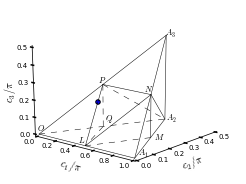

In [51]:
U_PE.show_in_weyl_chamber()

In [52]:
U_closest_PE = U_PE.closest_PE()

In [53]:
1-U_PE.F_avg(U_closest_PE)

0.0054810376621311496

In [37]:
U_target_PE = read_target_gate(rf+'/target_gate.dat')

In [40]:
1 - U_PE.F_avg(U_target_PE)

0.0054815980248310581

In [42]:
pulse_PE = Pulse(rf='/pulse.dat')

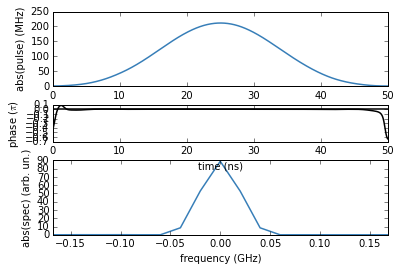

In [43]:
pulse_PE.show()

In [44]:
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)

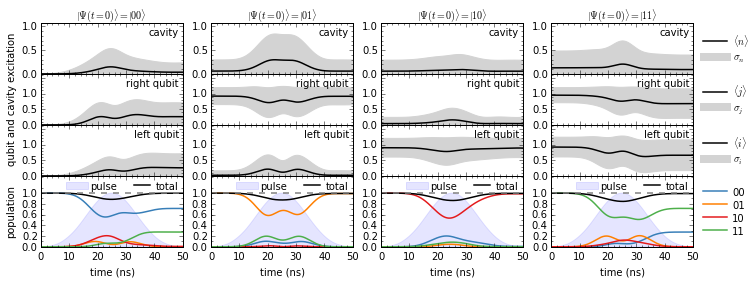

In [45]:
dyn.show()

#### Local Gates

In [55]:
U_HL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_H_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_HR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_H_right', 'pulse.dat', rwa=True, keep=None, force=True)
U_SL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_Ph_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_SR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/SQ_1freq_Ph_right', 'pulse.dat', rwa=True, keep=None, force=True)

In [57]:
1 - U_HL.F_avg(H_left)

0.0075158005242521586

In [58]:
1 - U_HR.F_avg(H_right)

0.0085389958986326064

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

### Pre Simplex

#### PE

In [47]:
rf = './runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4_1freq/PE_1freq'

In [48]:
U_PE = propagate(rf, 'pulse.dat', rwa=True, keep=True, force=True)

In [49]:
! cat {rf}/config | grep w_d

w_d = 5932.447856_MHz, &


In [50]:
U_PE.pop_loss()

0.0054792730019286306

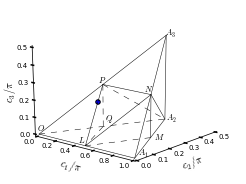

In [51]:
U_PE.show_in_weyl_chamber()

In [52]:
U_closest_PE = U_PE.closest_PE()

In [53]:
1-U_PE.F_avg(U_closest_PE)

0.0054810376621311496

In [37]:
U_target_PE = read_target_gate(rf+'/target_gate.dat')

In [40]:
1 - U_PE.F_avg(U_target_PE)

0.0054815980248310581

In [42]:
pulse_PE = Pulse(rf='/pulse.dat')

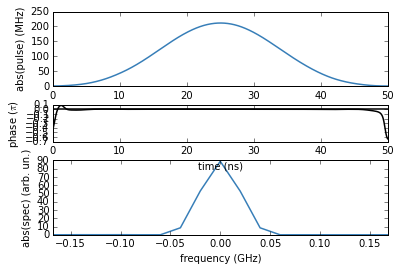

In [43]:
pulse_PE.show()

In [44]:
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)

#### Local Gates

In [55]:
U_HL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4_1freq/SQ_1freq_H_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_HR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4_1freq/SQ_1freq_H_right', 'pulse.dat', rwa=True, keep=None, force=True)
U_SL = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4_1freq/SQ_1freq_Ph_left', 'pulse.dat', rwa=True, keep=None, force=True)
U_SR = propagate('./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4_1freq/SQ_1freq_Ph_right', 'pulse.dat', rwa=True, keep=None, force=True)

In [57]:
1 - U_HL.F_avg(H_left)

0.0075158005242521586

In [58]:
1 - U_HR.F_avg(H_right)

0.0085389958986326064

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

In [60]:
1 - U_SL.F_avg(S_left)

0.0061055576024937608

## Analysis of PE result

In [38]:
rf = join(root, 'analyze_stage4_PE'); mkdir(rf)
! cp ./runs_050_RWA/w2_5900MHz_wc_6200MHz/stage4/PE_1freq/* {rf}/

In [39]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/analyze_stage4_PE'

In [40]:
pulse = AnalyticalPulse('1freq_rwa', T=50, nt=2000, time_unit='ns', ampl_unit='MHz',
                        parameters={'E0':0, 'T':50, 'w_L': 5.932442958862661, 
                                    'w_d': 5.932442958862661})

Concurrence: 0.0458042543442
Loss: 0.00448414597022


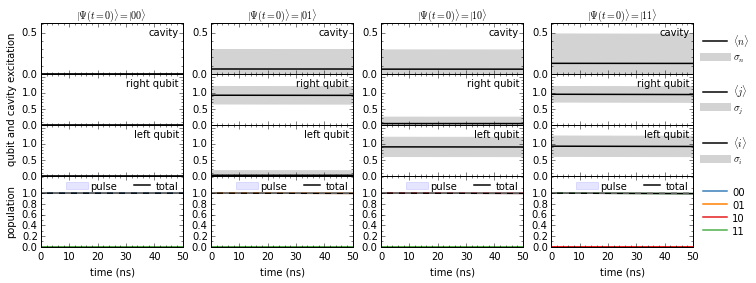

In [44]:
pulse.parameters['E0'] = 0.0
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.542123470378
Loss: 0.00462538567073


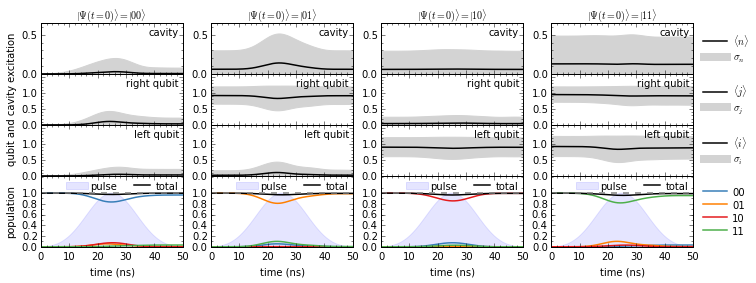

In [46]:
pulse.parameters['E0'] = 100
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.859652254126
Loss: 0.00484554218148


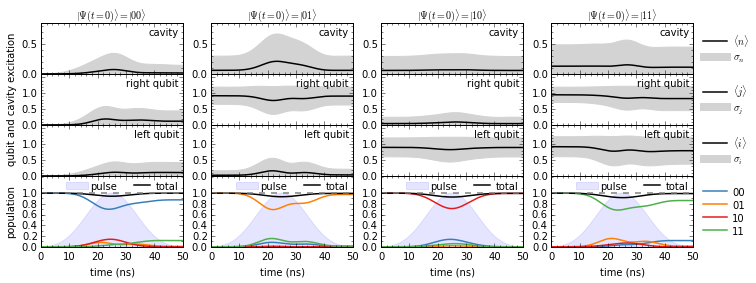

In [47]:
pulse.parameters['E0'] = 150
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

Concurrence: 0.99999934885
Loss: 0.00548104151986


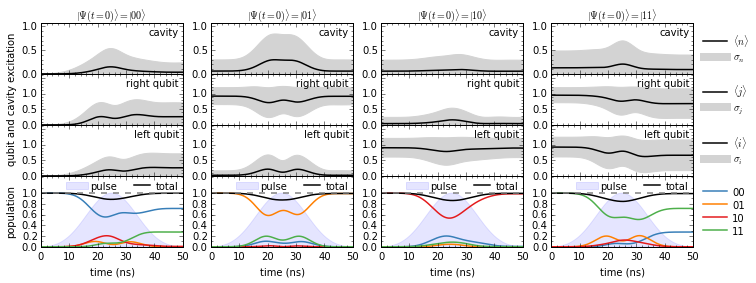

In [45]:
pulse.parameters['E0'] = 211.84807950325194
pulse.pulse().write(join(rf, 'pulse.dat'))
U = propagate(rf, 'pulse.dat', rwa=True, keep=all, force=True)
dyn = QDYNTransmonLib.popdyn.PopPlot(rf)
print "Concurrence: %s" % U.closest_unitary().concurrence()
print "Loss: %s" % U.pop_loss()
dyn.show()

## Further OCT

### PE

#### Shorter time duration

* $T = 40$

In [62]:
wd = 5.9325
rf = join(root, 'PE_40ns'); mkdir(rf)
T = 40

In [50]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_40ns'

In [54]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [55]:
proc = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [56]:
proc

<Process(Process-1, started)>

In [63]:
proc.join();

In [64]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True);

In [65]:
U.closest_unitary().concurrence()

0.99998071887803075

In [67]:
1-U.F_avg(U.closest_unitary())

0.0052472032625618947

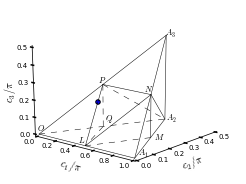

In [72]:
U.show_in_weyl_chamber()

* $T = 30$

In [57]:
wd = 5.9325
rf = join(root, 'PE_30ns'); mkdir(rf)
T = 30

In [58]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_30ns'

In [59]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [60]:
proc2 = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [61]:
proc2

<Process(Process-2, started)>

* $T = 20$

In [68]:
wd = 5.9325
rf = join(root, 'PE_20ns'); mkdir(rf)
T = 20

In [69]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_20ns'

In [70]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [71]:
proc3 = system("./run_oct.py --continue --threads --target=PE --rwa --scan=systematic_variation.json --vary=E0 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [61]:
proc3

<Process(Process-2, started)>

#### Known efficient gates

* SQRT(SWAP) at $T = 50ns$

In [75]:
wd = 5.9325
rf = join(root, 'PE_sqrtSWAP_50ns'); mkdir(rf)
T = 50

In [76]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_sqrtSWAP_50ns'

In [79]:
# write runfolder
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_SWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [80]:
proc4 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa --scan=systematic_variation.json --vary=E0 --nt-min=4000 --E0-min=30 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [81]:
proc4

<Process(Process-4, started)>

* SQRT(SWAP) at $T = 50ns$, no pre-simplex

Simplex did not seem successful, so let's try with a significant pulse amplitude instead

In [85]:
wd = 5.9325
rf = join(root, 'PE_sqrtSWAP_50ns_no_simplex'); mkdir(rf)
T = 50

In [86]:
rf

'./runs_zeta_detailed/w2_5900MHz_wc_6200MHz/PE_sqrtSWAP_50ns_no_simplex'

In [87]:
# write runfolder
nt = 4000
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')
write_target_gate_dat(rf, 'sqrt_SWAP')
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.pulse().write(join(rf, 'pulse.guess'))
vary = {'E0': [50, 100, 150, 200, 300, 400, 500]}
with open(join(rf, 'systematic_variation.json'), 'w') as out_fh:
    json.dump(vary, out_fh)

In [88]:
proc5 = system("./run_oct.py --continue --threads --target=target_gate.dat --rwa {rf}".format(rf=rf))

In [89]:
proc5

<Process(Process-5, started)>